In [22]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
/*Disable scrollbar in a cell*/

<IPython.core.display.Javascript object>

In [23]:
import os
import time
import SALib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import multiprocessing as mp
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import date
from pygam import LinearGAM, s, f
from SALib.sample import saltelli
from SALib.analyze import sobol, delta
from itertools import combinations, product
from sklearn.preprocessing import PolynomialFeatures

# Load data
name = 'par-sweep-6pars-t'
path_to_frame = f'../experiments/{name}/'
frame = pd.read_pickle(f"{path_to_frame}{name}.pkl")

# Format data
# Construct a dictionary of name (key) and title for plots (value)
names_bounds = {'single_utility_at_max': 'Utility at homogeneity (M)',
            'single_optimal_fraction': 'Optimal fraction ($t_i$)', 
            'radius': 'Radius (r)', 
            'neighbourhood_mixture': 'Neighbourhood mix (b)',
            'alpha': 'Alpha', 
            'school_capacity': 'School capacity (c)',
            'max_res_steps': 'Residential steps'}

var_params = {'single_utility_at_max': [0, 0.2, 0.4, 0.6, 0.8, 1],
                'single_optimal_fraction': [0.4, 0.45, 0.5, 0.55, 
                                            0.6, 0.65, 0.7, 0.75, 0.8],
                'radius': [1, 3, 5, 7, 9],
                'neighbourhood_mixture':[0, 0.2, 0.4, 0.6, 0.8, 1],
                'alpha':[0, 0.2, 0.4, 0.6, 0.8],
                 'max_res_steps':[0, 500]}
nominal_values = {'single_utility_at_max':0.6,
                'single_optimal_fraction':0.5,
                'radius':3,
                'neighbourhood_mixture':0.2,
                'alpha':0.2,
                 'max_res_steps':500}

In [25]:
# data = pd.read_pickle(f"{path_to_frame}distance-data-{name}.pkl")
# data.rename(columns=names_bounds, inplace=True)
# temp_data = data.copy()
# for name, value in nominal_values.items():
#     temp_data = temp_data[temp_data[names_bounds[name]]==value]
# print(temp_data.shape)

# General plot settings 

In [3]:
# print(mpl.rcParams.keys)
sns.set(style="whitegrid", font_scale=1.5)
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['grid.alpha'] = 1

# colors = itertools.cycle((',', '+', '.', 'o', '*'))
markers = ('o', 'v', 's', 'd', '<', '+')

# Function to save figures

In [4]:
# Create directory if it does not exist yet.
plot_path = f'../plots/{name}'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

def save_figure(plot_path, filename):
    today = date.today()
    _ = plt.savefig(f'{plot_path}/{filename}-{today.strftime("%d-%m-%Y")}.pdf')

In [5]:
# import sys
# sys.path.insert(0, "../compass")

# from parameters import FLAGS
# from model import CompassModel


# # Initialize
# size = 90
# FLAGS.width = size
# FLAGS.height = size
# FLAGS.n_neighbourhoods = 25
# FLAGS.n_schools = 25
# model = CompassModel(vars(FLAGS), export=False)
# school_distances = {}
# for school in model.get_agents('schools'):
#     school_distances[school.unique_id] = school.pos
# print(school_distances)

In [6]:
def calculate_distance(household):
    
    # Hardcode actual school locations (see code above)
    school_distances = {
     "25": (9, 9), "26": (9, 27), "27": (9, 45), "28": (9, 63), "29": (9, 81), 
     "30": (27, 9), "31": (27, 27), "32": (27, 45), "33": (27, 63), "34": (27, 81), 
     "35": (45, 9), "36": (45, 27), "37": (45, 45), "38": (45, 63), "39": (45, 81), 
     "40": (63, 9), "41": (63, 27), "42": (63, 45), "43": (63, 63), "44": (63, 81), 
     "45": (81, 9), "46": (81, 27), "47": (81, 45), "48": (81, 63), "49": (81, 81)}
    
    school = str(int(household.unit))
    euclid_dist = np.sqrt((household.loc_x - school_distances[school][0])**2 + \
                          (household.loc_y - school_distances[school][1])**2) \
    
    return euclid_dist

In [7]:
def extract_distance_compositions(filename):
    
    # Load the .npz file
    data = np.load(path_to_frame + filename + '.npz', allow_pickle=True)
    
    # Calculate the utility metrics for every time step
    household_data = pd.DataFrame(data['households'][-1, :, :], columns=data['households_headers'])
    household_data['actual_dist'] = [calculate_distance(household)
                                     for _, household in household_data.iterrows()]
    school_data = household_data.groupby(['unit', 'category']).agg(['count','mean'])['actual_dist']
    
    params = data['params'].item()
    params['majority_dist'] = school_data.groupby('unit').apply(lambda x: x.max())['mean'].mean()
    params['minority_dist'] = school_data.groupby('unit').apply(lambda x: x.min())['mean'].mean()
    
    return params

In [8]:
# chunksize = 50
# start = time.time()
# # frame = frame.sample(n=500)
# with mp.Pool() as p:
#     all_data = list(tqdm(p.imap(
#         extract_distance_compositions, frame.filename,
#         chunksize=chunksize), total=frame.filename.shape[0]))
# end = time.time()
# print("Time elapsed:", end - start)

# distance_data = pd.DataFrame(all_data)
# print(distance_data)

In [9]:
# Save or load the data depending on the calculations are already made
# distance_data.to_pickle(f"{path_to_frame}distance-data-{name}.pkl", protocol=4)
distance_data = pd.read_pickle(f"{path_to_frame}distance-data-{name}.pkl")

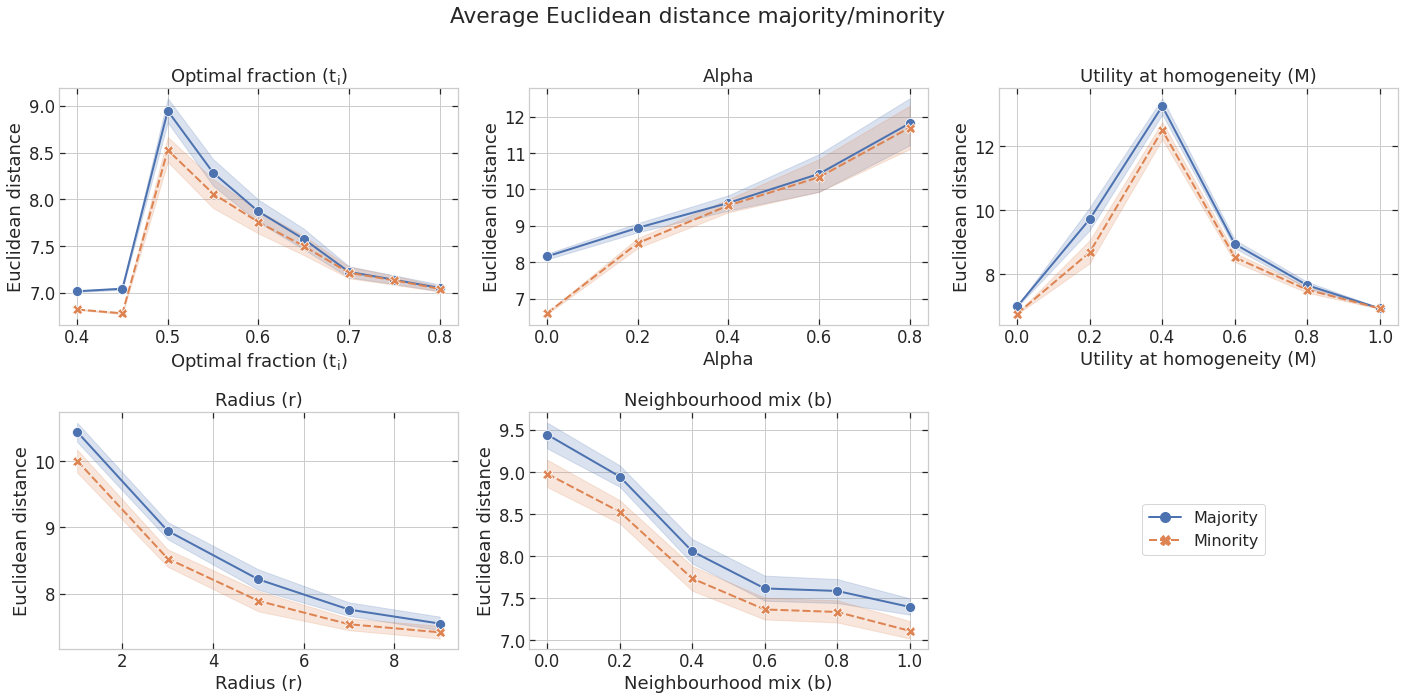

In [16]:
n_rows=2
n_cols=3
figsize=(20,10)
fig = plt.figure(figsize=figsize)

id_cols = distance_data.columns.drop(['majority_dist', 'minority_dist'])
data = pd.melt(distance_data, id_vars=id_cols, 
               value_vars=['majority_dist', 'minority_dist'],
               var_name='Majority', value_name='Distance utility')
data.rename(columns=names_bounds, inplace=True)
subset = {names_bounds[name]:var_params[name] for name in ['single_optimal_fraction',
            'alpha', 'single_utility_at_max', 'radius', 'neighbourhood_mixture']}

for i, var in enumerate(subset):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    
    var_range = subset[var]
    temp_data = data[data[var].isin(var_range)]
    
    for name, value in nominal_values.items():
        if names_bounds[name] != var:
            temp_data = temp_data[temp_data[names_bounds[name]]==value]
    
    sns.lineplot(x=var, 
                y='Distance utility', 
                hue='Majority',
                markers=True,
                style='Majority', ci=95,
                data=temp_data)
    h, l = ax.get_legend_handles_labels()
    ax.set_title(var)
    ax.legend_.remove()
    ax.set_ylabel('Euclidean distance')
#     plt.ylim(0.85, 1.)
    
fig.legend(h, ['Majority', 'Minority'], fontsize=16, bbox_to_anchor=(0.90, 0.3))
fig.tight_layout()
# plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.suptitle('Average Euclidean distance majority/minority')
plt.tight_layout(rect=[0, 0, 1, 0.98])
save_figure(plot_path, filename='distance-per-group')
plt.show()

# Archive